In [2]:
import torch
from IPython import display
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

In [3]:
# 数据加载
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='../data',
                                                   train=True,
                                                   download=True,
                                                   transform=trans)
    mnist_test = torchvision.datasets.FashionMNIST(root='../data',
                                                   train=False,
                                                   download=True,
                                                   transform=trans)
    return (data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4),
            data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=4))

In [4]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

/Users/wenyalan/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
# 查看batch数据大小
for i in train_iter:
    print(len(i))
    print(i[0].shape)
    print(i[1].shape)
    break

2
torch.Size([256, 1, 28, 28])
torch.Size([256])


In [14]:
# 模型初始化
input_nums = 28 * 28
output_nums = 10

W = torch.normal(mean=0, std=0.1, size=(input_nums, output_nums), requires_grad=True)
b = torch.zeros(output_nums, requires_grad=True)

In [15]:
W

tensor([[ 0.0237, -0.0111,  0.0070,  ..., -0.1063, -0.1135,  0.1486],
        [ 0.1156, -0.0279, -0.0398,  ..., -0.0876,  0.0238, -0.0729],
        [ 0.0079,  0.0310, -0.0363,  ..., -0.1519,  0.0916, -0.0104],
        ...,
        [-0.0364, -0.2359,  0.0679,  ...,  0.0599, -0.0054,  0.0051],
        [-0.0470,  0.0391,  0.1143,  ..., -0.0778,  0.0641,  0.0084],
        [ 0.0921,  0.0398, -0.0451,  ..., -0.0952, -0.0635, -0.1546]],
       requires_grad=True)

In [16]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

In [17]:
X.shape

torch.Size([2, 3])

In [20]:
X.sum(axis=0, keepdim=True)

tensor([[5., 7., 9.]])

In [22]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(axis=1, keepdim=True)
    return X_exp / partition

In [24]:
softmax(X).sum(axis=1)

tensor([1., 1.])

In [25]:
def net(X, w, b):
    return softmax(torch.matmul(X.reshape(-1, w.shape[0]), w) + b)
    

In [26]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y)), y])

In [27]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [28]:
def accuracy(y_hat, y):
    if len(y_hat) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [29]:
# 模型结果累加器
class Accumulator:
    def __init__(self, n):
        self.data = [0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [32]:
# 数据效果评估
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X, W, b), y), y.numel())
    return metric[0] / metric[1]

In [33]:
evaluate_accuracy(net, test_iter)

0.0654

In [41]:
def train_epoch(net, data_iter, loss, updater):
#     开启训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in data_iter:
        y_hat = net(X, W, b)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(len(y) * float(l), accuracy(y_hat, y), y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.size().numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [36]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [38]:
lr = 0.1
params = [W, b]
# 随机梯度下降法
def updater(batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [39]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

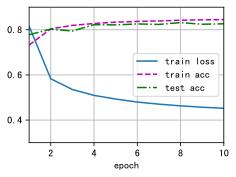

In [42]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [43]:
def get_fashion_mnist_labels(labels):
    text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
    'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [44]:
for X, y in test_iter:
    break

array([<AxesSubplot:title={'center':'pullover\ncoat'}>,
       <AxesSubplot:title={'center':'t-shirt\nt-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot\nankle boot'}>,
       <AxesSubplot:title={'center':'shirt\nshirt'}>,
       <AxesSubplot:title={'center':'dress\ndress'}>,
       <AxesSubplot:title={'center':'shirt\ncoat'}>], dtype=object)

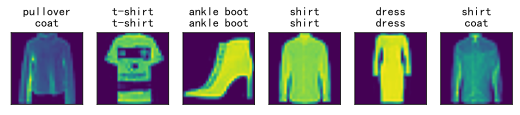

In [53]:
y_labels = get_fashion_mnist_labels(y)
y_pred_labels = get_fashion_mnist_labels(net(X, W, b).argmax(axis=1))

n = 6
titles = [true + '\n' + pred for true, pred in zip(y_labels, y_pred_labels)]
d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])